<h1>Part 1 - Exploratory Data Analysis</h1>

<h2>Problem Statement</h2>

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [2]:
#import packages
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


<h2>Takeaway</h2>



Before we get there, let's see the takeaway...

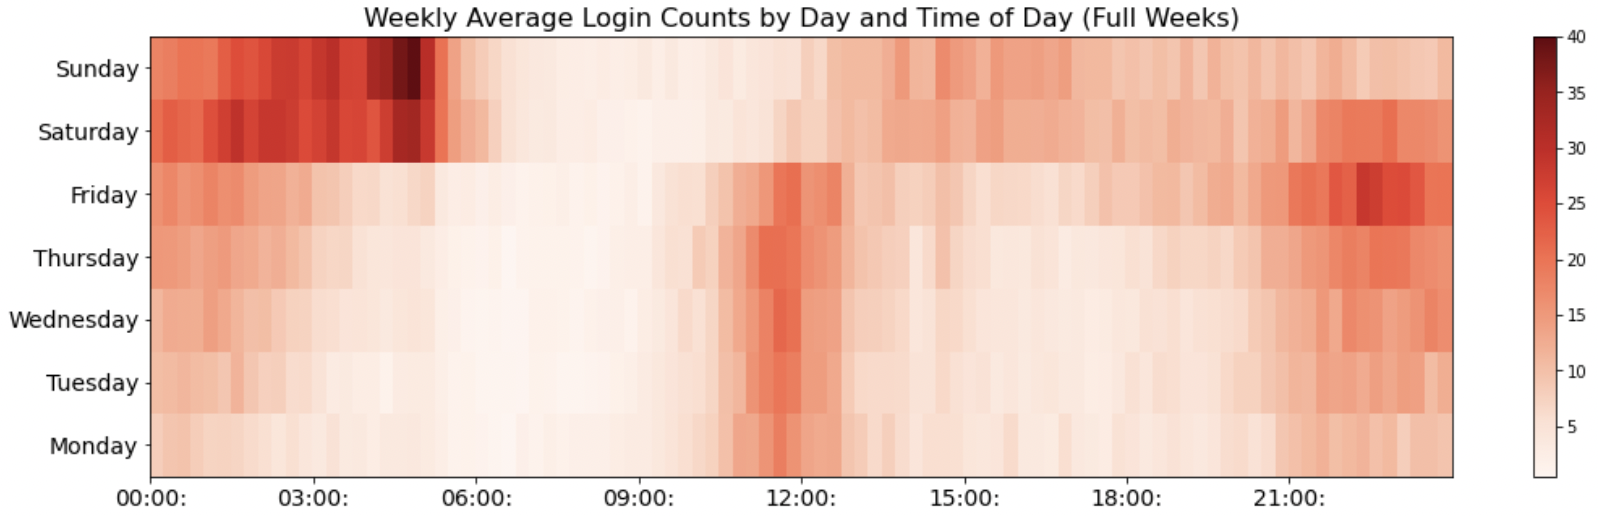

**0) There is probably a time-offset of 2/3-hours between analysis time and local time based on the rhythm of an average city.**

**1) Weekends are different than Weekdays.**

**2) Weekends tend to get their traffic later in the night - possibly due to entertainment.**

**3) Weekdays tend to get their traffic early in the day and mid-day - possibly due to work.**

**4) Friday seems to be belong to both "weekdays" based on its AM performance and "weekends" based on it PM performance.**

<h2>Exploratory Data Analysis</h2>


<h3>Import Data</h3>

In [3]:
logins_fn = "data/raw/logins.json"
data_df = pd.read_json(logins_fn,dtype=['datetime'])

print("Data - Head")
data_df.head()

Data - Head


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
print('Data - Info')
data_df.info()

Data - Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
#Since we have only one column, let's convert to pd.Series.
data = data_df['login_time']

#Let's figure out the number of unique elements along with some other descriptive statistics.
print('Unique elements: {0} out of {1}'.format(data.nunique(), len(data)))

data.describe(datetime_is_numeric=True)

Unique elements: 92265 out of 93142


count                            93142
mean     1970-02-26 19:09:39.779648278
min                1970-01-01 20:12:16
25%         1970-02-04 10:37:19.750000
50%         1970-03-01 06:33:05.500000
75%         1970-03-22 04:01:10.750000
max                1970-04-13 18:57:38
Name: login_time, dtype: object

In [6]:
data.head(10)

0   1970-01-01 20:13:18
1   1970-01-01 20:16:10
2   1970-01-01 20:16:37
3   1970-01-01 20:16:36
4   1970-01-01 20:26:21
5   1970-01-01 20:21:41
6   1970-01-01 20:12:16
7   1970-01-01 20:35:47
8   1970-01-01 20:35:38
9   1970-01-01 20:47:52
Name: login_time, dtype: datetime64[ns]

<h4>Some First-Pass Observations</h4>

1) From the above, we see that the data is from a 101-day period from 1/1/1970 to 4/13/1970. 

2) Given the problem context, the year is most likely not 1970 however would probably need an appropriate time offset. At this stage, this has a limited bearing on our analysis - with the caveat that time of the year (season, holidays) and geography (holiday schedules) might play a role on the interpretation of the data.

<h4>Generate Count For All 15-Min Intervals<\h4>

In [7]:
#Generate Counts
data_counts = data_df['login_time'].value_counts().sort_index(ascending=True)
print(data_counts)

1970-01-01 20:12:16    1
1970-01-01 20:13:18    1
1970-01-01 20:16:10    1
1970-01-01 20:16:36    1
1970-01-01 20:16:37    1
                      ..
1970-04-13 18:48:52    1
1970-04-13 18:50:19    1
1970-04-13 18:54:02    1
1970-04-13 18:54:23    1
1970-04-13 18:57:38    1
Name: login_time, Length: 92265, dtype: int64


In [8]:
#Aggregate Count for all 15-Min intervals
data_counts_15min = data_counts.groupby(pd.Grouper(freq='15Min')).agg('sum')
print("Data Count Grouped by 15-minute Intervals")

data_counts_15min = data_counts_15min.sort_index(ascending=True)
print(data_counts_15min)

count_start = data_counts_15min.index.min()
count_end = data_counts_15min.index.max()
print("\n\nStart and End Points for 15-minute Intervals")
print("Start: {0}\nEnd:   {1}".format(str(count_start), str(count_end)))

print("\nIntervals with Zero Count: {}".format(data_counts_15min[data_counts_15min==0].count()))

#Turn into a DataFrame for Further Processing
df = pd.DataFrame(data_counts_15min)
df.rename(mapper={'login_time':'login_count'}, axis=1, inplace=True)

Data Count Grouped by 15-minute Intervals
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Name: login_time, Length: 9788, dtype: int64


Start and End Points for 15-minute Intervals
Start: 1970-01-01 20:00:00
End:   1970-04-13 18:45:00

Intervals with Zero Count: 407


<h2>Graphs & Observations</h2>


<h3>15-Min Intervals - The Whole Period</h3>

In [9]:
df.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


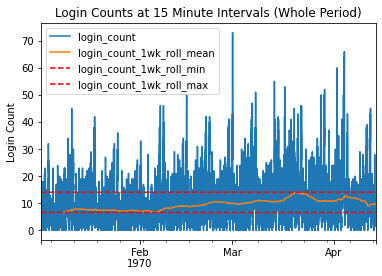

In [10]:


df[['login_count_1wk_roll_mean','login_count_1wk_roll_std']] = df['login_count'].rolling(pd.Timedelta(value='1W')).agg(['mean', 'std'])
df['login_count'].plot();
df.loc[df.index.min()+pd.Timedelta(value='1W'):,'login_count_1wk_roll_mean'].plot()
df['login_count_1wk_roll_min'] = df.loc[df.index.min()+pd.Timedelta(value='1W'):,'login_count_1wk_roll_mean'].min()
df['login_count_1wk_roll_min'].plot(color='r',style='--')
df['login_count_1wk_roll_max'] = df.loc[df.index.min()+pd.Timedelta(value='1W'):,'login_count_1wk_roll_mean'].max()
df['login_count_1wk_roll_max'].plot(color='r',style='--')
plt.ylabel('Login Count')
plt.title('Login Counts at 15 Minute Intervals (Whole Period)');
plt.legend();
df.drop(labels=['login_count_1wk_roll_min', 'login_count_1wk_roll_max'], axis=1, inplace=True)

**Three observations** from the above:

**OBS1)** The existence of **0s in may indicate downtime** for the system, perhaps depending on the time of day. 

**OBS2)** The **peaks in the graph may indicate special dates/events/hours** that one might want to pay more attention to.

**OBS3)** The **data seems to be cyclical** with a weekly frequency with a positive login count trend.

Let's chase down some of these leads.

<h4>OBS1) Slow Hours & Possible System Downtime</h4>
    
    
    
    
Let's take a look at the length of the "no-login" periods and visualize them

<h5>OBS1.a) Duration of No Logins for the Whole Period</h5>

Count of Durations with No Logins (Whole Period, Aggregate)
75      1
60      1
45     17
30     64
15    219
dtype: int64



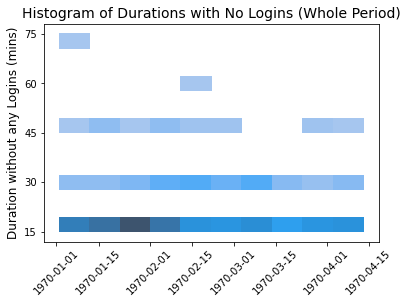

In [69]:
minutes_down_sr = pd.Series(dtype=int)

#Pass over login count data and extract no-login periods
prev_zero = False
zero_ct = 0
zero_idx = pd.NaT
for t_ct in df['login_count'].items():
    if t_ct[1] != 0:
        if prev_zero:
            minutes_down_sr[zero_idx] = 15*zero_ct
            prev_zero = False
        else:
            continue
    else:
        if prev_zero:
            zero_ct += 1
        else:
            prev_zero = True
            zero_idx = t_ct[0]
            zero_ct = 1
if prev_zero == True:  #check last item
    minutes_down_sr[zero_idx] = 15*zero_ct


minutes_down_sr.sort_values(ascending=False)[:20]


#Plot histogram of periods with no logins
ax = sns.histplot(data=minutes_down_sr, x=minutes_down_sr.index, y=minutes_down_sr.values)
plt.xticks(rotation=45)
plt.yticks(range(minutes_down_sr.min(), minutes_down_sr.max()+1,15));
plt.ylabel("Duration without any Logins (mins)",size=12)
plt.title("Histogram of Durations with No Logins (Whole Period)",size=14);
print('Count of Durations with No Logins (Whole Period, Aggregate)\n{}\n'.
      format(minutes_down_sr.value_counts().sort_index(ascending=False)))


<h5>Some Notes Re: OBS1.a) Duration of No Login Periods</h5>

1) A majority of the no-login periods (by count) are stand-alone while longer no-login periods (say, ≥45mins) are not that numerous.

2) Across the whole period, longer no-login periods tend to decrease in frequency closer to the end. 

Now, let's take a look at aggregate behavior throughout the day.

<h5>OBS1.b) Aggregate Behaviour of No Login Periods Across the Day</h5>

Let's aggregate the data based on time of day and observe the behavior.

In [13]:
#Introduce Columns 'date' and 'time' for visualization purposes
minutes_down_df = pd.DataFrame(minutes_down_sr, columns=['no_login_mins'])
minutes_down_df['date'] = minutes_down_df.index.date
minutes_down_df['time'] = minutes_down_df.index.hour+minutes_down_df.index.minute/60
print(minutes_down_df.columns)

Index(['no_login_mins', 'date', 'time'], dtype='object')


In [14]:
#Introduce the count of 'time' and 'no_login_min' pairs also for visualization purposes.
time_mins_pair_ct = minutes_down_df.groupby(by=['time', 'no_login_mins']).agg('count').reset_index()
time_mins_pair_ct.rename(mapper={'date':'time_no_login_min_ct'}, axis=1, inplace=True)
minutes_down_df = minutes_down_df.merge(time_mins_pair_ct, on=['time', 'no_login_mins'])

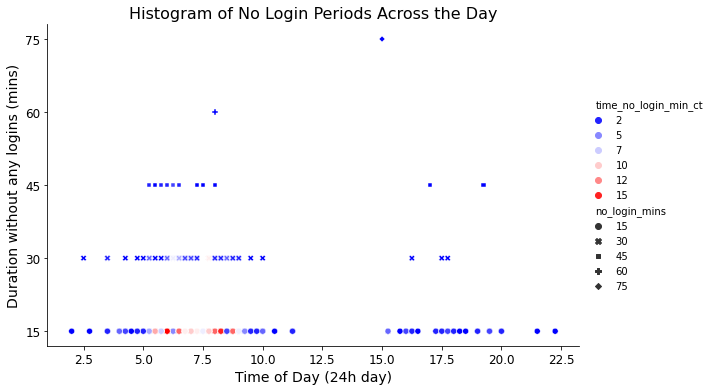

In [15]:
sns.relplot(data=minutes_down_df, 
            x='time', 
            y='no_login_mins',  
            style='no_login_mins', 
            hue='time_no_login_min_ct',
            aspect = 8/5,
            palette=plt.cm.bwr,
               )
plt.xticks(size=12)
plt.yticks(ticks=range(15,90,15), labels=range(15,90,15), size=12)
plt.xlabel('Time of Day (24h day)',size=14)
plt.ylabel('Duration without any logins (mins)',size=14)
plt.title('Histogram of No Login Periods Across the Day', size=16)
plt.show();

<h5>Some Observations Re: OBS1.b) Aggregate Behavior of No Login Periods Across the Day</h5>

0) Any assumption I make here is context dependent and should be double-checked. Also, given the data, we have no idea if the analysis timezone happens to be the timezone of the city.

1) Timewise, no login periods seem to be divided into two groups: AM and PM  where AM tends to contains most of the no login periods.

2) Within the AM group, the no login density seems to be more pronounced from 5:30am to 9:30am (see the darker shades). Assuming a regular city and a regular workday, this is highly counter-intuitive as users are most likely to look for trips at these times. **The system could probably benefit from a root-cause analysis of no logins at these times (e.g. system down vs no-demand) Resulting analysis could be fed into a supervised classification methodology to make estimates about system status in real time. E.g. Prob(SystemDown | No Login, Time of Day).**

3) Within the PM group, the no login periods are fewer. **These could also be actual down times and need to be checked. The next step in this analysis would be to compare, cross-sectionally, the average of same timelotss across other weeks (perhaps by zscore).**

4) **The data and clustering of no logins would make a lot more sense if the analysis timezone were ahead of the  city timezone - say by 3 hours. In that case the AM no-login behavior would fall between 2:30am and 6:30am - which is more in tune with the daily rhythms.**

<h4>OBS2) Peak Usage</h4>
    
    
    
    
Let's see if there might be some patterns in peak login periods

<h5>OBS2.a) Durations with High Login Counts (Whole Period)</h5>

For this part, let's define High Login Counts in a relative sense and observe the data.

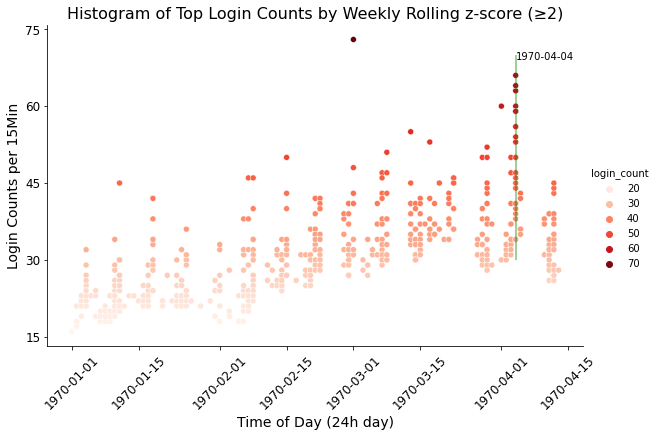

In [17]:
min_login_ct_zscore = 2
df['login_count_1wk_roll_zscore'] = (df['login_count'] - df['login_count_1wk_roll_mean'])/df['login_count_1wk_roll_std']

top_login_cts = df[df['login_count_1wk_roll_zscore']>=min_login_ct_zscore]
#print(len(top_login_cts))
#Turn into a DataFrame for Further Processing
top_logins_df = pd.DataFrame(top_login_cts)
top_logins_df['date'] = top_logins_df.index.date
top_logins_df['time'] = top_logins_df.index.hour+top_logins_df.index.minute/60

sns.relplot(data=top_logins_df, 
            x='date', 
            y='login_count',  
            hue = 'login_count',
            aspect = 8/5,
            palette='Reds',
               )
plt.xticks(size=12, rotation=45)
plt.yticks(ticks=range(15,90,15), labels=range(15,90,15), size=12)
plt.xlabel('Time of Day (24h day)',size=14)
plt.ylabel('Login Counts per 15Min',size=14)
plt.title('Histogram of Top Login Counts by Weekly Rolling z-score (≥{0:d})'.format(min_login_ct_zscore), size=16)
plt.vlines(datetime.datetime(year=1970, month=4, day=4), ymin=30, ymax=70, color='green', alpha=0.5)
plt.annotate('1970-04-04', xy = (93,69))
plt.show();

<h5>Some Notes Re: OBS2.a) Durations with High Login Counts (Whole Period)</h5>

1) High login counts seem to show cyclicality in **2- to 3-day bursts - most likely indicating weekends**.

2) Across the whole period, the increase in high top login counts over time could be attributed to the positive trend displayed in the first section.

3) It could also make sense to analyze the cause of the peak on 1970-04-04 (green line.)

Now, let's take a look at aggregate behavior throughout the day.

<h5>OBS2.b) Aggregate Behaviour of High Login Periods Across the Day</h5>

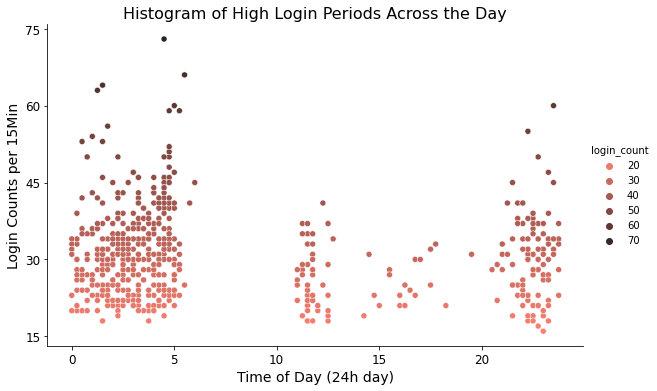

In [18]:
sns.relplot(data=top_logins_df, 
            x='time', 
            y='login_count',   
            hue='login_count',
            aspect = 8/5,
            palette='dark:salmon_r',
               )
plt.xticks(size=12)
plt.yticks(ticks=range(15,90,15), labels=range(15,90,15), size=12)
plt.xlabel('Time of Day (24h day)',size=14)
plt.ylabel('Login Counts per 15Min',size=14)
plt.title('Histogram of High Login Periods Across the Day', size=16)
plt.show();

<h5>Some Notes Re: OBS2.b) Aggregate Behaviour of High Login Periods Across the Day</h5>

1) High login counts tend to concentrate late at night from 11pm to 5am. This might indicate **heavy use across morning hours and looks like it precedes the low usage behavior displayed above**.

2) For this type of use, **the argument for a timezone discrepancy is still valid (~3hours)**. That would also move the 11am-12am peak to morning-rush.

Now, let's take a look at cyclical behavior and try to understand the user behavior better.

<h4>OBS3) Cyclical Patterns</h4>
    
    
    
    
Let's see if there might be some patterns for period longer than a day.

<h5>OBS3.a) Weekly Logins - Daily Comparison</h5>


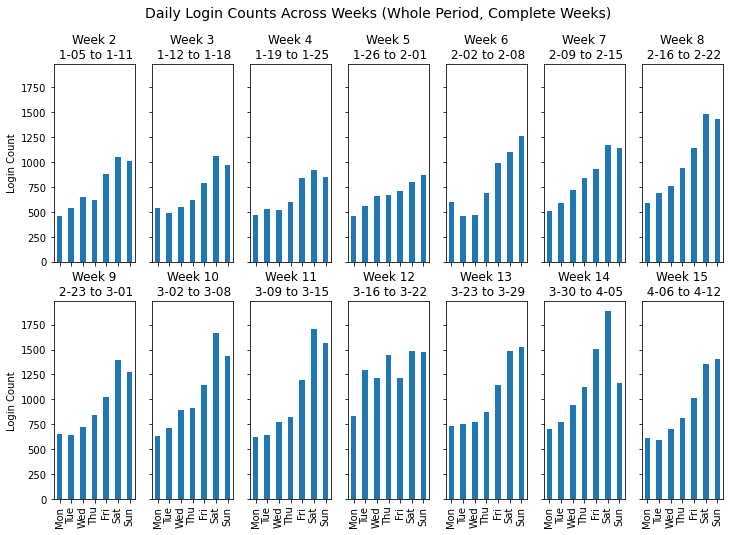

In [19]:
df['time'] = df.index.time
df['_week'] = df.index.day_of_week
df['week'] = df.index.isocalendar().week  #complete weeks are 2 through 15 [incl]
days = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]

df_fullwk_filter = (df['week']>=2) & (df['week']<=15)
df_fullwk = df[df_fullwk_filter]
df_fullwk_pvt_dayfocus = df_fullwk.pivot_table(index='week', columns='day_of_week', values='login_count', aggfunc='sum', fill_value=0)

nrows, ncols= 2, 7
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex = True, sharey=True,)
for i,wk in enumerate(df_fullwk_pvt_dayfocus.index.sort_values()):
    _ax = ax[i//ncols, i%ncols]
    _ax =df_fullwk_pvt_dayfocus.loc[wk,:].plot(kind='bar',ax=_ax)
    _wk_start = df[df['week']==wk]['week'].index.min()
    _wk_end = _wk_start + pd.Timedelta("6D")  
    _ax.set_title('Week {0}\n {1} to {2}'.format(wk, str(_wk_start.date())[6:], str(_wk_end.date())[6:]))
    _ax.set_ylabel('Login Count')
    _ax.set_xlabel('')
    _ax.set_xticks(ticks=range(0,7))
    _ax.set_xticklabels(labels=[days[_][:3] for _ in df_fullwk_pvt_dayfocus.columns])
fig.set_size_inches(12,8)
fig.suptitle('Daily Login Counts Across Weeks (Whole Period, Complete Weeks)', size=14);


<h5>Some Notes Re: OBS3.a) Weekly Logins Daily Comparison</h5>

1) **Across the weeks, the graphs are similar**: Login counts seems to **increase throughout the week with the highest login counts appearing towards the weekend** (i.e. Friday, Saturday, Sunday).

Now, let's take a look at the days a little bit more closely in the context of a week. 

<h5>OBS3.b) Picture of an "Average" Week - by Day</h5>

Let's see what the average login counts for each 15Min interval look like across weeks and see if that tells us a story about the login behavior. 

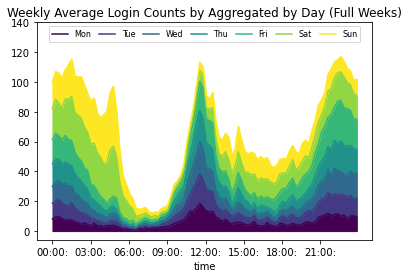

In [20]:
df_fullwk_pvt_timefocus = pd.pivot_table(data = df_fullwk, 
                        values = 'login_count', 
                        index='time', 
                        columns='day_of_week', 
                        fill_value = 0,
                        aggfunc='sum')

df_fullwk_pvt_timefocus_wkavg = df_fullwk_pvt_timefocus/14


ax = df_fullwk_pvt_timefocus_wkavg.plot(kind='area', colormap='viridis')
ax.legend([_[:3] for _ in days], fontsize=8, ncol=7, columnspacing=1, loc='upper center');
xlabels = [str(_v)[:-2] for _i, _v in enumerate(df_fullwk_pvt_timefocus.index) if _i%12==0]
ax.set_xticks(ticks=range(0,86000,86000//8))
ax.set_xticklabels(labels=xlabels)
ax.set_ylim(ymax=140)
ax.set_title('Weekly Average Login Counts by Aggregated by Day (Full Weeks)');

<h5>Some Notes Re: OBS3.b) Picture of an "Average" Week - by Day</h5>

1) Let's note the three spikes that happen between 12am-3am, 9am-11am and 7pm-8pm - which most likely correspond to higher ride demand at those time (most likely with some time offset.)

2) Let's also note the pattern reversal on weekdays vs weekends (inc Fri pm). Whereas weekdays make up the larger part of the 9am-11am spike (possibly due to commute), weekends make the larger part of the late-night spike (12am-3am). Evening spike from 7pm to 8pm seems to be more equally distributed, though still slightly favoring the weekend pattern.

Now, let's take a look at the whole picture as a heatmap over days and 15Min intervals.

<h5>OBS3.c) Picture of an "Average" Week - by Day and Time of Day</h5>

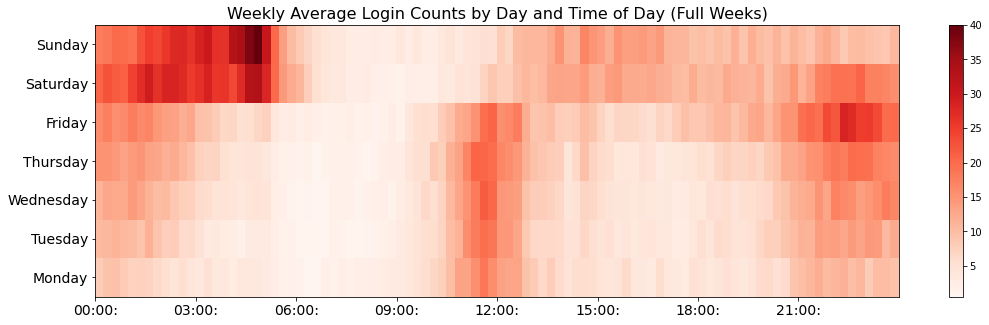

In [21]:
_values = df_fullwk_pvt_timefocus_wkavg.values
ax = plt.pcolormesh(_values.T, cmap=plt.cm.Reds)

xlabels = [str(_v)[:-2] for _i, _v in enumerate(df_fullwk_pvt_timefocus_wkavg.index) if _i%12==0]
ylabels = [days[_] for _ in df_fullwk_pvt_timefocus_wkavg.columns]
plt.xticks(ticks = range(0,96,12),labels=xlabels, size=14)
plt.yticks(ticks = np.arange(0.5,7.5,1), labels=ylabels, size=14)

plt.gcf().set_figwidth(18)
plt.gcf().set_figheight(5)
plt.title('Weekly Average Login Counts by Day and Time of Day (Full Weeks)', size=16)
plt.colorbar();

<h5>Some Notes Re: OBS3.c) Picture of an "Average" Week - by Day and Time of Day</h5>

**0) There is probably a time-offset of 2/3-hours between analysis time and local time based on the rhythm of an average city.**

**1) Weekends are different than Weekdays.**

**2) Weekends tend to get their traffic later in the night - possibly due to entertainment.**

**3) Weekdays tend to get their traffic early in the day and mid-day - possibly due to work.**

**4) Friday seems to be belong to both "weekdays" based on its AM performance and "weekends" based on it PM performance.**
